Reconocimiento de las imágenes de CIFAR10 (cats vs dogs) usando una CNN
===

* *30 min* | Última modificación: Abril 6, 2020.

Basado en https://www.tensorflow.org/tutorials/images/classification

## Importación de librerías

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

print(tf.__version__)

#
# Librerias adicionales para graficación
#
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.1.0


## Carga y configuración del dataset

In [2]:
#
# Descarga el arhivo desde una URL y retorna la 
# localización del archivo en el disco duro. 
# El archivo es descomprimido automáticamente.
#
path_to_zip = tf.keras.utils.get_file(
    fname="cats_and_dogs.zip",
    origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
    extract=True,
)

#
# Directorio del dataset
# 
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")

#
# directorios para la muestra de entrenamiento
#
train_dir = os.path.join(PATH, "train")
train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

#
# Directorios para la muestra de validación
#
validation_dir = os.path.join(PATH, "validation")
validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

## Exploración del dataset

In [3]:
#
#  Cantidad de imágenes
# 
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print("total training cat images:", num_cats_tr)
print("total training dog images:", num_dogs_tr)
print("--")
print("total validation cat images:", num_cats_val)
print("total validation dog images:", num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


## Preparación de los datos

In [4]:
#
#  Parámetros para la generación de los datasets 
#  de entrenamiento y validación
#
batch_size = 128
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [5]:
#
# Generación del dataset de entrenamiento
#

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary",
)

Found 2000 images belonging to 2 classes.


In [6]:
#
#  Generación del dataset de validación
#

validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)  

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary",
)

Found 1000 images belonging to 2 classes.


## Visualización de las imágenes

In [7]:
#
#  Función para la visualización de imágenes
#
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

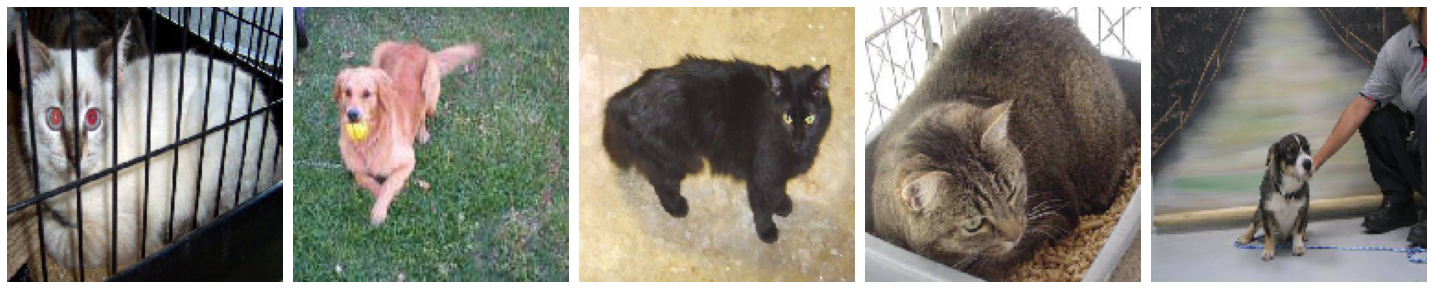

In [8]:
#
#  Visualización de las imágenes del
#  dataset de entrenamiento
#
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

## Creación y compilación del modelo base

In [9]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            16,
            3,
            padding="same",
            activation="relu",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

## Entrenamiento del modelo base sobre el dataset original

In [10]:
EPOCHS = 16

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
)

Train for 15 steps, validate for 7 steps
Epoch 1/16
15/15 [==============================] - 22s 1s/step - loss: 1.1001 - accuracy: 0.5064 - val_loss: 0.6812 - val_accuracy: 0.5078
Epoch 2/16
15/15 [==============================] - 23s 2s/step - loss: 0.6607 - accuracy: 0.5646 - val_loss: 0.6548 - val_accuracy: 0.5748
Epoch 3/16
15/15 [==============================] - 24s 2s/step - loss: 0.6172 - accuracy: 0.6277 - val_loss: 0.6113 - val_accuracy: 0.6741
Epoch 4/16
15/15 [==============================] - 31s 2s/step - loss: 0.5719 - accuracy: 0.6797 - val_loss: 0.6202 - val_accuracy: 0.6127
Epoch 5/16
15/15 [==============================] - 32s 2s/step - loss: 0.5184 - accuracy: 0.7185 - val_loss: 0.5820 - val_accuracy: 0.7042
Epoch 6/16
15/15 [==============================] - 35s 2s/step - loss: 0.4743 - accuracy: 0.7628 - val_loss: 0.6047 - val_accuracy: 0.6540
Epoch 7/16
15/15 [==============================] - 31s 2s/step - loss: 0.4255 - accuracy: 0.7890 - val_loss: 0.5914 - 

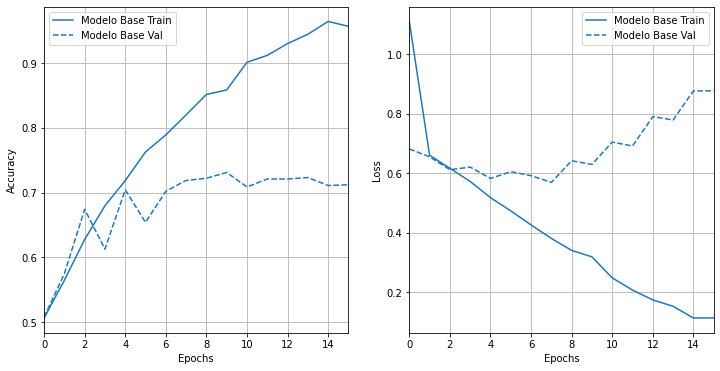

In [11]:
#
#  El modelo presenta sobre entrenamiento
#
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
tfdocs.plots.HistoryPlotter().plot({'Modelo base': history}, metric = "accuracy")
plt.subplot(1, 2, 2)
tfdocs.plots.HistoryPlotter().plot({'Modelo base': history}, metric = "loss")

## Aumento del tamaño del dataset

### Por giro horizontal de la imágen

Found 2000 images belonging to 2 classes.


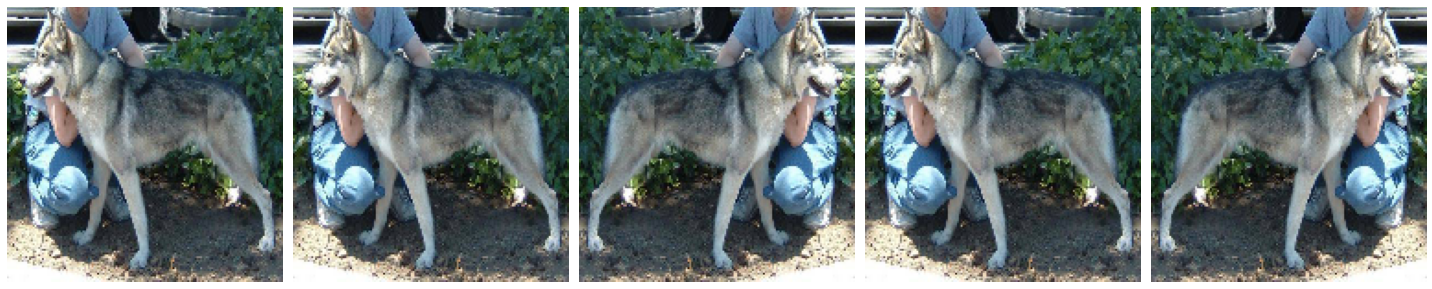

In [12]:
#
#  Ejemplo
#

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

### Por rotación aleatoria de la imagen

Found 2000 images belonging to 2 classes.


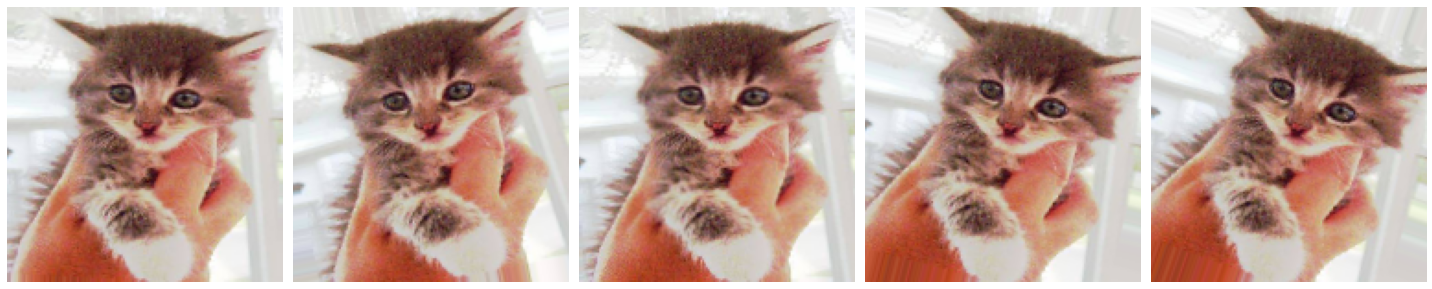

In [13]:
#
#  Ejemplo
#

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

### Por zoom de la imágen

Found 2000 images belonging to 2 classes.


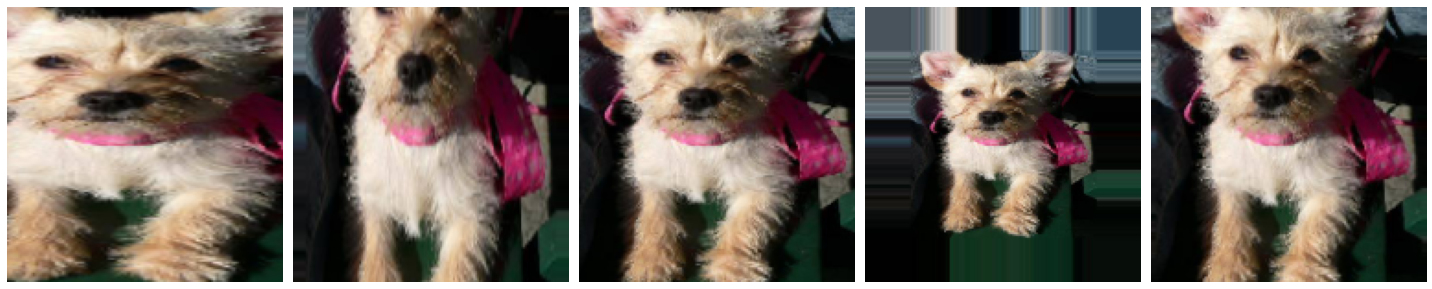

In [14]:
#
#  Ejemplo
#

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255, zoom_range=0.5) 

train_data_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

### Aumento de las imágenes del dataset de entrenamiento

Found 2000 images belonging to 2 classes.


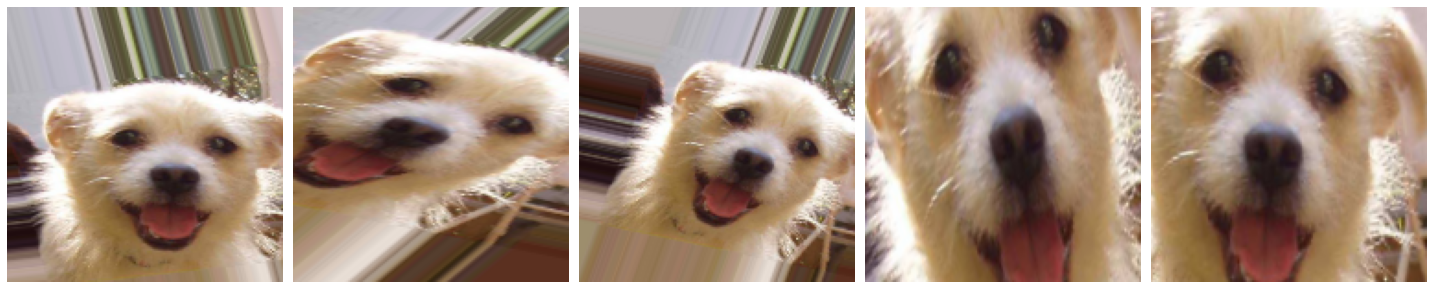

In [15]:
image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.5,
)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary",
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Generador de datos de validación

In [16]:
image_gen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary",
)

Found 1000 images belonging to 2 classes.


## Especificación y compilación del nuevo modelo

In [17]:
#
#  Este modelo tiene la misma configuración del modelo base
#  pero adiciona Dropout para evitar el sobreajuste.
#
model_new = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            16,
            3,
            padding="same",
            activation="relu",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model_new.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

## Entrenamiento del nuevo modelo

In [19]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=EPOCHS,
    validation_data=val_data_gen,
)

Train for 15 steps, validate for 8 steps
Epoch 1/16
15/15 [==============================] - 27s 2s/step - loss: 1.0526 - accuracy: 0.5069 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 2/16
15/15 [==============================] - 27s 2s/step - loss: 0.6913 - accuracy: 0.4989 - val_loss: 0.6859 - val_accuracy: 0.5000
Epoch 3/16
15/15 [==============================] - 29s 2s/step - loss: 0.6841 - accuracy: 0.5150 - val_loss: 0.6696 - val_accuracy: 0.5670
Epoch 4/16
15/15 [==============================] - 28s 2s/step - loss: 0.6734 - accuracy: 0.5524 - val_loss: 0.6606 - val_accuracy: 0.5610
Epoch 5/16
15/15 [==============================] - 34s 2s/step - loss: 0.6778 - accuracy: 0.5427 - val_loss: 0.6743 - val_accuracy: 0.5340
Epoch 6/16
15/15 [==============================] - 38s 3s/step - loss: 0.6672 - accuracy: 0.5609 - val_loss: 0.6668 - val_accuracy: 0.5460
Epoch 7/16
15/15 [==============================] - 36s 2s/step - loss: 0.6657 - accuracy: 0.5566 - val_loss: 0.6551 - 

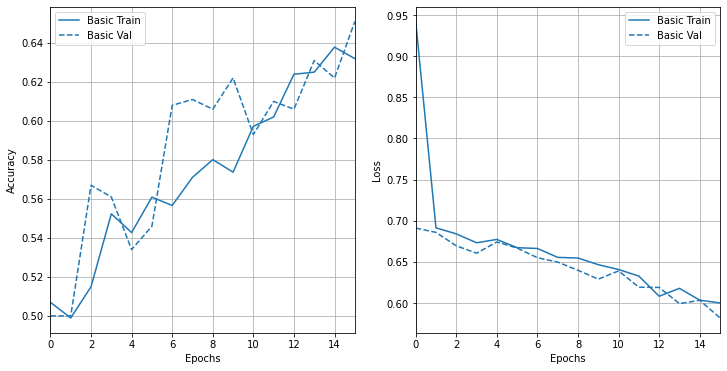

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
tfdocs.plots.HistoryPlotter().plot({'Basic': history}, metric = "accuracy")
plt.subplot(1, 2, 2)
tfdocs.plots.HistoryPlotter().plot({'Basic': history}, metric = "loss")

In [21]:
#
#  Historia
#
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.942222,0.506944,0.691141,0.500,0
1,0.691402,0.498932,0.685899,0.500,1
2,0.684121,0.514957,0.669612,0.567,2
3,0.673284,0.552350,0.660640,0.561,3
4,0.677347,0.542735,0.674306,0.534,4
5,0.667302,0.560897,0.666800,0.546,5
6,0.666360,0.556624,0.655101,0.608,6
7,0.655522,0.571047,0.649812,0.611,7
8,0.654745,0.580128,0.639831,0.606,8
9,0.646651,0.573718,0.629052,0.622,9
